In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import pickle
import itertools
import requests
import re
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from IPython.display import display, HTML, Markdown
from lightgbm import LGBMClassifier
from matplotlib.ticker import FuncFormatter
from keras.callbacks import Callback
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, concatenate, Bidirectional, \
    GlobalAveragePooling1D, GlobalMaxPooling1D, CuDNNGRU, CuDNNLSTM, GRU, LSTM
from keras.models import Model
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.wrappers.scikit_learn import KerasClassifier
from scikitplot.metrics import plot_confusion_matrix as pcm
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import cross_val_predict, StratifiedKFold, train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
display(HTML("<style>.container { width:60% !important; }</style>"))
pd.set_option('max_colwidth', 400)

Using TensorFlow backend.


In [2]:
notes = pd.read_csv('notes_cui.csv')
notes.head()

,text,Nutrition,Cognitive,Exercise,Footwear,cui,text_cui
0,"GENERAL APPEARANCE: Well developed, well nourished, alert and cooperative, and appears to be in no acute distress. HEENT: Eyes PERRL, EOMI. Fundi normal, vision is grossly intact. Teeth and gingiva in good general condition. NECK: Neck supple, non-tender without lymphadenopathy, masses or thyromegaly. No JVD or HJR. CARDIAC: Normal S1 and S2. No S3, S4 or murmurs. Rhythm is regular. There is n...",1,1,0,0,C0017562 C0007765 C0037004 C0015392 C0015385 C0019552 C0740422 C0024109 C0040426 C0018787 C0000726 C0027342 C0021853 C0027530 C1123023 C0022417 C0302142 C0042345 C0012634 C0018808 C0043144 C0042789 C0010520 C0332516 C0231303 C0006318 C0034642 C0034929 C0239110 C0427198 C0221198 C0030232 C1642390 C0239949 C0497156 C0013604 C0035508 C0425687 C0036658 C0018021 C0231683 C0030987 C0004339,"GENERAL APPEARANCE: Well developed, well nourished, alert and cooperative, and appears to be in no acute distress. HEENT: Eyes PERRL, EOMI. Fundi normal, vision is grossly intact. Teeth and gingiva in good general condition. NECK: Neck supple, non-tender without lymphadenopathy, masses or thyromegaly. No JVD or HJR. CARDIAC: Normal S1 and S2. No S3, S4 or murmurs. Rhythm is regular. There is n..."
1,"GENERAL APPEARANCE: Alert and cooperative. HEENT: Eyes PERRL, EOMI. Fundi normal, vision is grossly intact. NECK: Neck supple, non-tender without lymphadenopathy, masses or thyromegaly. No JVD or HJR. CARDIAC: Normal S1 and S2. No S3, S4 or murmurs. Rhythm is regular. Extremities are warm and well perfused. No carotid bruits. LUNGS: Clear to auscultation and percussion without rales, rhonchi, ...",0,1,0,0,C0007765 C0037004 C0015392 C0015385 C0019552 C0740422 C0024109 C0018787 C0000726 C0027342 C0021853 C1123023 C0027530 C0022417 C0302142 C0042345 C0018808 C0043144 C0042789 C0332516 C0006318 C0034642 C0034929 C0239110 C0427198 C0221198 C1642390 C0239949 C0497156 C0035508 C0013604 C0425687 C0036658 C0018021 C0231683 C0030987 C0004339,"GENERAL APPEARANCE: Alert and cooperative. HEENT: Eyes PERRL, EOMI. Fundi normal, vision is grossly intact. NECK: Neck supple, non-tender without lymphadenopathy, masses or thyromegaly. No JVD or HJR. CARDIAC: Normal S1 and S2. No S3, S4 or murmurs. Rhythm is regular. Extremities are warm and well perfused. No carotid bruits. LUNGS: Clear to auscultation and percussion without rales, rhonchi, ..."
2,"GENERAL APPEARANCE: Well developed, and well nourished. HEENT: Eyes PERRL, EOMI. Fundi normal, vision is grossly intact. Teeth and gingiva in good general condition. NECK: Neck supple, non-tender without lymphadenopathy, masses or thyromegaly. No JVD or HJR. CARDIAC: Normal S1 and S2. No S3, S4 or murmurs. Rhythm is regular. There is no peripheral edema, cyanosis or pallor. Extremities are war...",1,0,0,1,C0017562 C0007765 C0015392 C0037004 C0015385 C0019552 C0740422 C0024109 C0040426 C0018787 C0000726 C0027342 C0021853 C1123023 C0027530 C0022417 C0302142 C0042345 C0012634 C0018808 C0043144 C0042789 C0010520 C0332516 C0006318 C0034642 C0034929 C0221198 C0427198 C0030232 C1642390 C0239949 C0497156 C0013604 C0035508 C0425687 C0036658 C0018021 C0231683 C0344211 C0030987 C0004339,"GENERAL APPEARANCE: Well developed, and well nourished. HEENT: Eyes PERRL, EOMI. Fundi normal, vision is grossly intact. Teeth and gingiva in good general condition. NECK: Neck supple, non-tender without lymphadenopathy, masses or thyromegaly. No JVD or HJR. CARDIAC: Normal S1 and S2. No S3, S4 or murmurs. Rhythm is regular. There is no peripheral edema, cyanosis or pallor. Extremities are war..."
3,"GENERAL APPEARANCE: Well developed, well nourished, alert and cooperative, and appears to be in no acute distress. HEENT: Eyes PERRL, EOMI. Fundi normal, vision is grossly intact. Teeth and gingiva in good general condition. NECK: Neck supple, non-tender without lymphadenopathy, masses or thyromegaly. No JVD or HJR. CARDIAC: Normal S1 and S2. No S3, S4 or murmurs. Rhythm is regular. There is n..."

In [3]:
# prepare input
X_txt = notes.text_cui
y = notes[notes.columns.drop(['text', 'cui', 'text_cui'])]

In [4]:
# Helper function to evaluate

def printmd(string):
    display(Markdown(string))

def plot_confusion_matrix(cm, classes, ax,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title, loc='left')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.sca(ax)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

def evaluate_features(X, y, clf=None, model_prefix='BOW_'):
    
    if clf is None :
        clf = LogisticRegression()
        mclf = MultiOutputClassifier(clf)
        mclf.fit(X, y)
    elif type(clf).__name__ in ['SVC', 'LGBMClassifier', 'GaussianNB']:
        mclf = MultiOutputClassifier(clf)
        mclf.fit(X, y)
    elif type(clf).__name__ in ['KerasClassifier']:
        mclf = MultiOutputClassifier(clf)
    else:
        mclf = clf
        mclf.fit(X, y)
        
    clf_name = type(clf).__name__
    #display(Markdown('<strong>{}</strong><br/>'.format(clf_name)))
    
    if type(clf).__name__ in ['KerasClassifier']:
        pass
    else:
        pickle.dump(mclf, open('pickle/' + model_prefix + clf_name + '.pickle', 'wb'))
        
    _, ax = plt.subplots(ncols=4, figsize=(25,25))
    for j, i in enumerate(y):
        probas = cross_val_predict(clf, X, y[i], method='predict_proba')
        pred_indices = np.argmax(probas, axis=1)
        classes = np.unique(y[i])
        preds = classes[pred_indices]
        title = u'Prediction using ' + clf_name + \
            u'\nfor ' + i + ':'+ \
            u'\n\u2022 Log loss: {0:.2f}'.format(log_loss(y[i], probas)) + \
            u'\n\u2022 AUC: {0:.2f}'.format(roc_auc_score(y[i], probas[:, 1])) + \
            u'\n\u2022 Accuracy: {0:.2f}'.format(accuracy_score(y[i], preds)) + \
            u'\n\nConfusion Matrix:'
        cm = confusion_matrix(y[i], preds)
        plot_confusion_matrix(cm, classes, title=title, ax=ax[j])

In [5]:
# Helper function to evaluate
def evaluate_features(X, y, clf=None, model_prefix='BOW_'):
    
    if clf is None :
        clf = LogisticRegression()
        mclf = MultiOutputClassifier(clf)
        mclf.fit(X, y)
    elif type(clf).__name__ in ['SVC', 'LGBMClassifier', 'GaussianNB']:
        mclf = MultiOutputClassifier(clf)
        mclf.fit(X, y)
    elif type(clf).__name__ in ['KerasClassifier']:
        mclf = MultiOutputClassifier(clf)
    else:
        mclf = clf
        mclf.fit(X, y)
        
    clf_name = type(clf).__name__
    #display(Markdown('<strong>{}</strong><br/>'.format(clf_name)))
    
    if type(clf).__name__ in ['KerasClassifier']:
        pass
    else:
        pickle.dump(mclf, open('pickle/' + model_prefix + clf_name + '.pickle', 'wb'))
        
    _, ax = plt.subplots(ncols=4, figsize=(25,25))
    for j, i in enumerate(y):
        probas = cross_val_predict(clf, X, y[i], method='predict_proba')
        pred_indices = np.argmax(probas, axis=1)
        classes = np.unique(y[i])
        preds = classes[pred_indices]
        title = u'Prediction using ' + clf_name + \
            u'\nfor ' + i + ':'+ \
            u'\n\u2022 Log loss: {0:.2f}'.format(log_loss(y[i], probas)) + \
            u'\n\u2022 AUC: {0:.2f}'.format(roc_auc_score(y[i], probas[:, 1])) + \
            u'\n\u2022 Accuracy: {0:.2f}'.format(accuracy_score(y[i], preds)) + \
            u'\n\nConfusion Matrix:'
        cm = confusion_matrix(y[i], preds)
        plot_confusion_matrix(cm, classes, title=title, ax=ax[j])

In [6]:
# preprocessing 
max_features = 60000
maxlen = 1000
embed_size = 300
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_txt)
X_seq = tokenizer.texts_to_sequences(X_txt) 
X_seq = pad_sequences(X_seq, maxlen=maxlen)
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
# save tokenizer
with open('pickle/W2V_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
# helper functions
def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')

def get_embedding_matrix(embeddings_index, word_index, max_features, embed_size):
    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.zeros((nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: 
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i-1] = embedding_vector
    return embedding_matrix

# model function
def get_model(embedding_matrix, nb_words, model_type='GRU'):
    inp = Input(shape=(maxlen, ))
    x = Embedding(nb_words, embed_size, weights=[embedding_matrix])(inp)
    x = SpatialDropout1D(0.4)(x)
    if model_type=='CuDNNGRU':
        x = Bidirectional(CuDNNGRU(80, return_sequences=True))(x)
    elif model_type=='GRU':
        x = Bidirectional(GRU(80, return_sequences=True))(x)
    elif model_type=='CuDNNLSTM':
        x = Bidirectional(CuDNNLSTM(80, return_sequences=True))(x)
    elif model_type=='LTSM':
        x = Bidirectional(LSTM(80, return_sequences=True))(x)
    else:
        raise ValueError('Please specify model_type as one of the following:n\CuDNNGRU, CuDNNLSTM, GRU, LSTM')
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    outp = Dense(1, activation="sigmoid")(conc)
    
    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [8]:
#prepare embedding matrix
EMBEDDING_FILE = '../toxic/data/crawl-300d-2M.vec' #word2vec
pretrained_embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE, encoding="utf-8"))
pretrained_embedding_matrix = get_embedding_matrix(embeddings_index=pretrained_embeddings_index, word_index=word_index, max_features=max_features, embed_size=embed_size)

In [9]:
def get_model_new():
    inp = Input(shape=(maxlen, ))
    x = Embedding(nb_words, embed_size, weights=[pretrained_embedding_matrix])(inp)
    x = SpatialDropout1D(0.4)(x)
    x = Bidirectional(LSTM(80, return_sequences=True))(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    outp = Dense(1, activation="sigmoid")(conc)
    
    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

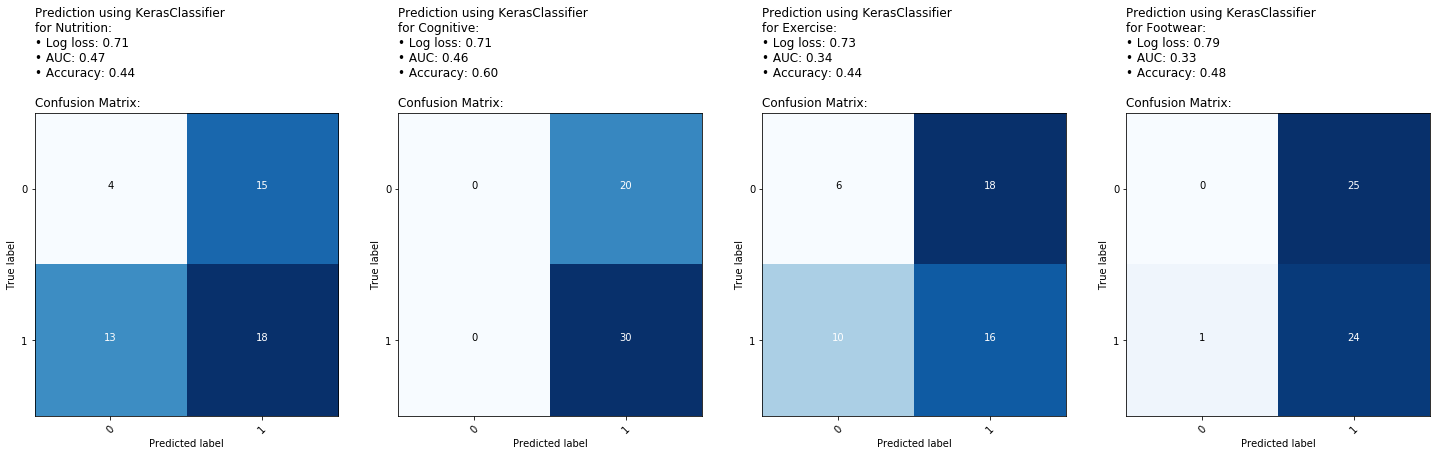

In [10]:
warnings.filterwarnings('ignore', category=DeprecationWarning)
k_clf = KerasClassifier(build_fn=get_model_new, batch_size=32, epochs=2, verbose=0)
evaluate_features(X_seq, y, k_clf)

# Using Own Embedding

In [22]:
# word2vec
document = X_txt.apply(lambda x: simple_preprocess(x))
w2v_model = Word2Vec(document, iter=10, min_count=10, size=embed_size, workers=4)

In [23]:
# prepare embedding matrix
own_embeddings_index = dict(zip(w2v_model.wv.index2word, w2v_model.wv.vectors))
own_embedding_matrix = get_embedding_matrix(embeddings_index=own_embeddings_index, word_index=word_index, max_features=max_features, embed_size=embed_size)

In [24]:
own_embeddings_index['diabetes']

array([ 0.06367829,  0.00931545,  0.09101325,  0.00691585, -0.06926794,
        0.14740415,  0.04345161,  0.07315542, -0.00205336, -0.05758995,
        0.03213312, -0.00736352, -0.01313657,  0.05099512, -0.0144088 ,
        0.02315473,  0.0447634 , -0.01557951, -0.01594647, -0.01284147,
       -0.01358295, -0.03895983, -0.00036152,  0.0454744 , -0.02780083,
        0.00688449,  0.02502027, -0.04013848, -0.03160403, -0.03823483,
        0.04645794,  0.13915013,  0.16177735, -0.14268732,  0.07078513,
       -0.16229111, -0.00991929,  0.03545905,  0.06560833,  0.01296237,
        0.03186741,  0.03922428, -0.00789557, -0.03010438, -0.0026707 ,
       -0.02829458,  0.06426924, -0.01782642,  0.07618477,  0.10648938,
        0.02893854,  0.07803998,  0.0211139 , -0.01805685, -0.00108268,
       -0.04367384, -0.01036508,  0.08031824, -0.02423587,  0.05652766,
        0.06246735, -0.06422344,  0.18890005, -0.05512656,  0.04104038,
        0.01062779,  0.0667776 ,  0.2520007 , -0.00081962, -0.01

RuntimeError: Cannot clone object <keras.wrappers.scikit_learn.KerasClassifier object at 0x7f7560730978>, as the constructor either does not set or modifies parameter embedding_matrix

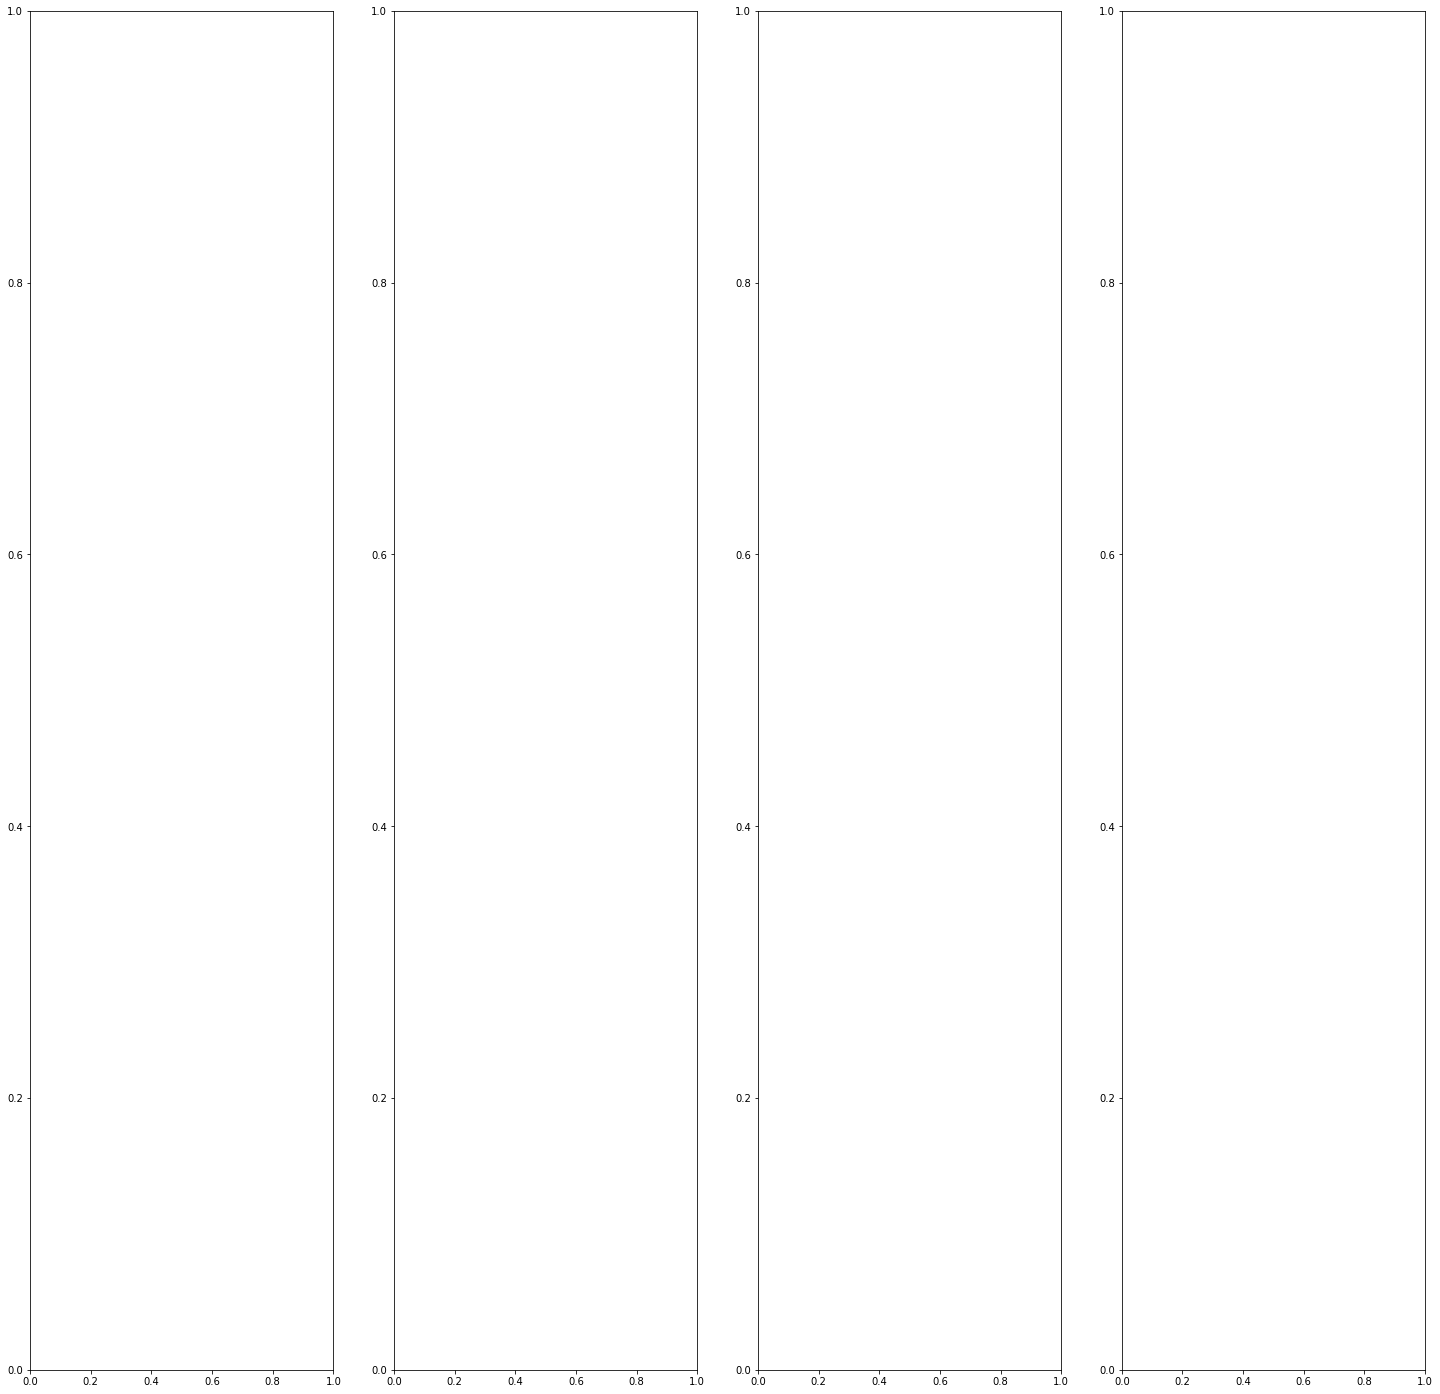

In [25]:
warnings.filterwarnings('ignore', category=DeprecationWarning)
k_clf = KerasClassifier(build_fn=get_model, batch_size=32, epochs=2, model_type='GRU', verbose=0, embedding_matrix=own_embedding_matrix, nb_words=nb_words)
evaluate_features(X_seq, y, k_clf)

In [29]:
# features extraction
max_features = 60000
maxlen = 100
embed_size = 300
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_txt)
X_train_txt, X_test_txt, y_train, y_test = train_test_split(X_txt, y)
X_train_seq = tokenizer.texts_to_sequences(X_train_txt) 
X_test_seq = tokenizer.texts_to_sequences(X_test_txt) 

In [30]:
X_train_txt[4]

'GENERAL APPEARANCE: Alert and cooperative. HEENT: Eyes PERRL, EOMI. Fundi normal, vision is grossly intact. NECK: Neck supple, non-tender without lymphadenopathy, masses or thyromegaly. No JVD or HJR. CARDIAC: Normal S1 and S2. No S3, S4 or murmurs. Rhythm is regular. Extremities are warm and well perfused. No carotid bruits. LUNGS: Clear to auscultation and percussion without rales, rhonchi, wheezing or diminished breath sounds. Good excursions. ABDOMEN: Negative bowel sounds. Hard, distended, tender. No guarding or rebound. No masses. EXTREMITIES: Some deformity in finger and wrists, showing signs of arthritis. No edema. Peripheral pulses intact. No varicosities. Strength at shoulder/elbow/wrist/hand 5/5 bilaterally. Strength at hips/knees/ankles 5/5 bilaterally. NEUROLOGICAL: CN II-XII intact. Strength and sensation symmetric and intact throughout. Reflexes 2+ throughout. Cerebellar testing normal. SKIN: Skin and nails normal, with no lesions. '

In [31]:
print(X_train_seq[4])

[59, 60, 17, 26, 140, 10, 58, 16, 41, 2, 42, 3, 43, 20, 62, 12, 5, 21, 22, 4, 68, 3, 66, 133, 69, 70, 24, 35, 4, 46, 47, 28, 3, 29, 25, 7, 32, 37, 38, 4, 13, 3, 71, 36, 7, 23, 110, 45, 167, 213, 153, 79, 175, 30, 149, 251, 252, 253]


In [32]:
X_train = pad_sequences(X_train_seq, maxlen=maxlen) # padding short truncate long 
X_test = pad_sequences(X_test_seq, maxlen=maxlen) # padding short truncate long 
# split into train validation
X_trn, X_val, y_trn, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2018)
# save tokenizer
with open('pickle/W2V_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [33]:
X_train[4]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,  59,  60,  17,  26, 140,  10,  58,  16,  41,   2,
        42,   3,  43,  20,  62,  12,   5,  21,  22,   4,  68,   3,  66,
       133,  69,  70,  24,  35,   4,  46,  47,  28,   3,  29,  25,   7,
        32,  37,  38,   4,  13,   3,  71,  36,   7,  23, 110,  45, 167,
       213, 153,  79, 175,  30, 149, 251, 252, 253], dtype=int32)

In [34]:
# prepare embedding function
#EMBEDDING_FILE = 'data/wiki.simple.vec' #fasttext
EMBEDDING_FILE = '../toxic/data/crawl-300d-2M.vec' #word2vec
def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE, encoding="utf-8"))

In [35]:
embeddings_index.get('diabetes')

array([ 5.300e-02,  1.425e-01,  2.356e-01,  3.250e-02,  1.524e-01,
       -5.285e-01, -6.986e-01,  2.940e-01, -1.846e-01,  2.978e-01,
       -4.154e-01,  5.373e-01, -9.230e-02, -8.650e-02,  7.130e-01,
       -2.158e-01,  2.450e-02,  4.117e-01,  3.225e-01,  1.768e-01,
        2.857e-01,  4.545e-01,  3.074e-01,  0.000e+00,  2.206e-01,
        3.640e-02, -1.090e-01, -5.035e-01,  2.112e-01,  2.529e-01,
       -1.290e-01,  4.502e-01,  1.751e-01, -2.473e-01, -2.301e-01,
        9.140e-02,  1.990e-02, -2.478e-01,  2.615e-01,  1.470e-02,
       -2.760e-02,  2.488e-01, -3.096e-01,  1.380e-02,  6.531e-01,
        4.195e-01, -1.694e-01, -2.369e-01,  2.680e-02,  1.500e-03,
       -5.027e-01, -1.930e-01,  8.134e-01,  1.928e-01, -1.722e-01,
        6.280e-02,  3.229e-01,  4.060e-02,  1.645e-01, -1.127e-01,
       -2.610e-02, -1.232e-01,  7.720e-02, -2.452e-01, -2.149e-01,
       -1.474e-01,  2.956e-01, -2.539e-01, -2.238e-01,  9.540e-02,
        1.480e-02, -1.058e-01, -3.460e-01,  1.490e-01, -1.605e

In [36]:
tokenizer.word_index.get('diabetes')

59

In [37]:
# word embedding
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_size))

In [38]:
for word, i in word_index.items():
    if i >= max_features: 
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: 
        embedding_matrix[i-1] = embedding_vector

In [39]:
# prepare model metrics
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))

In [40]:
# build model
def get_model(model_type='CuDNNGRU'):
    inp = Input(shape=(maxlen, ))
    x = Embedding(nb_words, embed_size, weights=[embedding_matrix])(inp)
    x = SpatialDropout1D(0.4)(x)
    if model_type=='CuDNNGRU':
        x = Bidirectional(CuDNNGRU(80, return_sequences=True))(x)
    elif model_type=='GRU':
        x = Bidirectional(GRU(80, return_sequences=True))(x)
    elif model_type=='CuDNNLSTM':
        x = Bidirectional(CuDNNLSTM(80, return_sequences=True))(x)
    elif model_type=='LTSM':
        x = Bidirectional(LSTM(80, return_sequences=True))(x)
    else:
        raise ValueError('Please specify model_type as one of the following:n\CuDNNGRU, CuDNNLSTM, GRU, LSTM')
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    outp = Dense(y.shape[1], activation="sigmoid")(conc)
    
    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [28]:
# train the model 
model = get_model(model_type='GRU')
batch_size = 32
epochs = 2
RocAuc = RocAucEvaluation(validation_data=(X_val, y_val), interval=1)
hist = model.fit(X_trn, y_trn, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val),
                 callbacks=[RocAuc], verbose=1)

TypeError: get_model() missing 1 required positional argument: 'embedding_matrix'

In [ ]:
model.save('model/BiGRU.h5')
model.evaluate(X_test, y_test)

In [ ]:
y_pred = model.predict(X_test, verbose=0)
score = roc_auc_score(y_test, y_pred)
print("\n ROC-AUC for test data - score: %.6f \n" % score)

In [ ]:
labels = notes.columns.drop('text')
for i, j in enumerate(labels):
    test = y_test.iloc[:,i]
    score = roc_auc_score(test, y_pred[:,i])
    pred = np.round(y_pred[:,i])
    title = "\n ROC-AUC for %s - score: %.6f \n" % (j, score)
    pcm(test,pred,normalize=True,title=title)